In [72]:
import os
import numpy as np
import matplotlib.pyplot as plt
from utils import loadMNISTLabels, loadMNISTImages, preprocess
from copy import deepcopy

# from mlp_functions import backprop, test, predict

# %% Load images and labels
path = '../MNIST_data'
def get_path(path, file):
    return os.path.join(path, file)

ytest = loadMNISTLabels(get_path(path, 't10k-labels.idx1-ubyte'))
ytrain = loadMNISTLabels(get_path(path, 'train-labels.idx1-ubyte'))

Xtest_raw = loadMNISTImages(get_path(path, 't10k-images.idx3-ubyte'))
Xtrain_raw = loadMNISTImages(get_path(path, 'train-images.idx3-ubyte'))

print(np.shape(Xtrain_raw))

(60000, 28, 28)


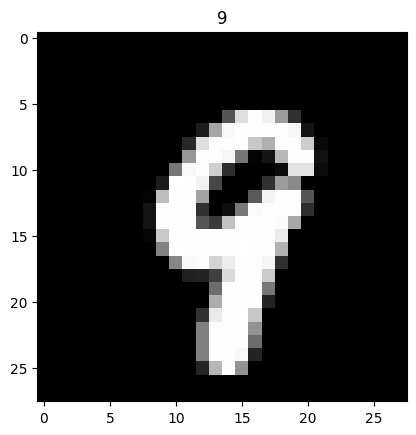

In [4]:
# %% display a random image with label:
img_index = np.random.randint(np.size(Xtrain_raw, axis=0))
img = Xtrain_raw[img_index, :, :]
plt.imshow(img, cmap='gray')
plt.title(str(ytrain[img_index]))
plt.show()

In [73]:
# %% preprocess the images (reshape to vectors and subtract mean)
Xtrain = preprocess(Xtrain_raw)
Xtest = preprocess(Xtest_raw)


In [55]:
# %% Parameters
# The first and last values in layer_sizes should be equal to the input and
# output dimensions respectively. Try different values for the layer sizes
# inbetween and see how they affect the performance of the network.

layers_sizes = [784, 64, 10] # flexible, but must be [784,...,10]
epochs = 4      # number of times to repeat over the whole training set
eta = 0.1       # learning rate
batch_size = 30 # number of samples in each training batch


In [56]:
# %% Initialize weights
# The weights are initialized to normally distributed random values. Note
# that we scale them by the previous layer size so that the input to
# neurons in different layers will be of similar magnitude.

def get_new_weights(layers_sizes):
    n_weights = len(layers_sizes)-1
    weights = np.zeros((n_weights,), dtype=np.ndarray)
    for i in range(n_weights):
        weights[i] = np.divide(np.random.standard_normal((layers_sizes[i+1],layers_sizes[i])), layers_sizes[i])
    return weights

weights = get_new_weights(layers_sizes)

In [41]:
for i in range(len(weights)):
    print(np.shape(weights[i]))

(32, 784)
(16, 32)
(10, 16)


In [ ]:
# %% Training
N = np.size(Xtrain, axis=0)                        # number of samples
n_mbs = np.ceil(N/batch_size).astype(np.int16)    # number of minibatches

In [ ]:
def get_activation_function():
    return np.tanh


def get_activation_function_derivative():
    return lambda x: 1 - np.tanh(x)**2


def predict(weights, X):
    """
    The function takes as input an array of the weights and a matrix (X)
    with images. The outputs should be a vector of the predicted
    labels for each image, and a matrix whose columns are the activation of
    the last layer for each image.
    last_layer_activation should be of size [10 X num_samples]
    predicted_labels should be of size [1 X num_samples]
    The predicted label should correspond to the index with maximal
    activation in the last layer
    :param weights: array of the network weights
    :param X: samples matrix (match the dimensions to your input)
    :return:
    """
    activation_function = get_activation_function()
    s_layer = X.T
    for i in range(0, len(weights)):
        _, s_layer = forword_pass_one_layer(weights[i], s_layer, activation_function)
    predicted_labels = np.argmax(s_layer, axis=0)
    return predicted_labels, s_layer

def digit_to_one_hot(y):
    one_hot = np.zeros((10, len(y)))
    one_hot[y, np.arange(len(y))] = 1
    return one_hot

def one_hot_to_digit(one_hot):
    return np.argmax(one_hot, axis=0)

def get_loss(y_hat, y):
    return 0.5 * np.mean((np.sum((y_hat - digit_to_one_hot(y))**2, axis=0)))

def test(weights, Xtest, ytest):
    """
    This function receives the Network weights, a matrix of samples and
    the corresponding labels, and outputs the classification
    accuracy and mean loss.
    The accuracy is equal to the ratio of correctly labeled images.
    The loss is given the square distance of the last layer activation
    and the 0-1 representation of the true label
    Note that ytest in the MNIST data is given as a vector of labels from 0-9. To calculate the loss you
    need to convert it to 0-1 (one-hot) representation with 1 at the position
    corresponding to the label and 0 everywhere else (label "2" maps to
    (0,0,1,0,0,0,0,0,0,0) etc.)
    :param weights: array of the network weights
    :param Xtest: samples matrix (match the dimensions to your input)
    :param ytest: corresponding labels
    :return:
    """
    predicted_labels, y_hat = predict(weights, Xtest)
    loss = get_loss(y_hat, ytest)
    accuracy = np.mean(predicted_labels == ytest)
    return accuracy, loss




def backprop(weights, X, y):
    """
    This function receives a set of weights, a matrix with images
    and the corresponding labels. The output should be an array
    with the gradients of the loss with respect to the weights, averaged over
    the samples. It should also output the average loss of the samples.
    :param weights: an array of length L where the n-th cell contains the
    connectivity matrix between layer n-1 and layer n.
    :param X: samples matrix (match the dimensions to your input)
    :param y: corresponding labels
    :return:
    """
    
    
    activation_function = get_activation_function()
    activation_function_derivative = get_activation_function_derivative()
    h_layers, s_layers = forward_pass(weights, X, activation_function)
    backword_pass(weights, h_layers, s_layers, y, activation_function_derivative)
    print(np.shape(s_layers[-1]))

    # return grads, mean_loss

def backword_pass(weights, h_layers, s_layers, y, activation_function_derivative):
    delta_layers = get_delta_layers(weights, h_layers, s_layers, y, activation_function_derivative)
    number_of_samples = len(y)
    weights_derivatives = get_gradients_tensor(delta_layers, s_layers, number_of_samples)
    return weights_derivatives


# tensor[l][miu][i][j] = the derivative of the loss with respect to the weight connecting the i-th neuron in the l+1-th layer
# and the j-th neuron in the l-th layer for the miu-th sample in the batch
def get_gradients_tensor(delta_layers, s_layers, number_of_samples):
    tensor = np.zeros((len(delta_layers),), dtype=np.ndarray)
    for i in range(len(delta_layers), 0):
        tensor[i] = np.zeros((number_of_samples, len(delta_layers[i]), len(s_layers[i-1])))
        for miu in range(number_of_samples):
            tensor[i][miu] = np.outer(delta_layers[i][:,miu], s_layers[i][:,miu])
    


# delta[l][i][miu] = the derivative of the loss with respect to the activation of the i-th neuron in the l-th layer 
# and the miu-th sample in the batch
def get_delta_layers(weights, h_layers, s_layers, y, activation_function_derivative):
    delta_layers = np.zeros((len(weights),), dtype=np.ndarray)
    for i in range(len(weights)-1, -1, -1):
        if i == len(weights)-1:
            delta_layers[i] = (s_layers[i] - digit_to_one_hot(y)) * activation_function_derivative(h_layers[i])
        else:
            delta_layers[i] = np.dot(weights[i+1].T, delta_layers[i+1]) * activation_function_derivative(h_layers[i])
    return delta_layers


def forword_pass_one_layer(weights, s_layer, activation_function):
    next_h_layer =  np.dot(weights, s_layer)
    next_s_layer = activation_function(next_h_layer)
    return next_h_layer, next_s_layer


def forward_pass(weights, X, activation_function):
    number_of_layers = len(weights)+1
    h_layers = np.zeros((number_of_layers,), dtype=np.ndarray)
    s_layers = np.zeros((number_of_layers,), dtype=np.ndarray)
        
    s_layer =  deepcopy(X.T)
    s_layers[0] = s_layer
    for i in range(1, number_of_layers):
        h_layer, s_layer = forword_pass_one_layer(weights[i], s_layer, activation_function)
        h_layers[i] = h_layer
        s_layers[i] = s_layer
        
    return h_layers, s_layers


backprop(weights, Xtrain[50:120,:], ytrain[50:120])
# print(test(weights, Xtest, ytest))

In [77]:
Xtrain[50:120,:].shape
# print(test(weights, Xtest, ytest))

(70, 784)

In [ ]:
# create vectors to keep track of loss:
batch_loss = np.empty((epochs * n_mbs, )) * np.nan
test_loss = np.empty((epochs * n_mbs, )) * np.nan
test_acc = np.empty((epochs * n_mbs, )) * np.nan
iteration = 0
for i in range(epochs):
    perm = np.random.permutation(N)
    for j in range(n_mbs):
        idxs = perm[(batch_size * j):min((batch_size * (j+1))-1, N-1)]

        # pick a batch of samples:
        X_mb = Xtrain[idxs, :]
        y_mb = ytrain[idxs]

        # compute the gradients:
        grads, loss = backprop(weights, X_mb, y_mb)

        # keep track of the batch loss
        batch_loss[iteration] = loss

        # uncomment the next line to keep track of test loss and error.
        # test_acc[iteration], test_loss[iteration]= test(weights,Xtest,ytest);
        # Note: evaluating the test_loss for each batch will slow down
        # computation. If it is too slow you can instead evaluate the test
        # loss at a lower frequency (once every 10 batches or so...)

        # update the weights:
        for k in range(len(weights)):
            weights[k] = weights[k] - eta * grads[k]

        iteration = iteration + 1  # counts the number of updates

    acc, loss = test(weights, Xtest, ytest)
    print('Done epoch %d, test accuracy: %f\n' % (i, acc))


In [ ]:
# %% Plot some results
# Example plot of the learning curve
fig, ax1 = plt.subplots()
ax1.plot(batch_loss, 'r-', label='Training loss')
ax1.plot(test_loss, 'k-', label='Test loss')
ax1.set_xlabel('Iteration')
ax1.set_ylabel('Loss')

ax2 = ax1.twinx()
ax2.plot(test_acc, label='Test accuracy')
ax2.set_ylabel('Accuracy')
fig.legend()
plt.show()


In [2]:
# %% Display 10 misclassifications with highest loss
# Example showing some misclassifications
yhat, output = predict(weights, Xtest)
t = np.zeros((10,len(ytest)))
for i in range(len(ytest)):
    t[ytest[i], i] = 1

test_losses = sum((output-t)**2)
sorted_index = np.argsort(-test_losses) # - for descending
idxs = sorted_index[:10]

plt.figure()
for k in range(10):
    ax = plt.subplot(2, 5, k+1)
    x = Xtest_raw[idxs[k], :, :]
    ax.imshow(x)
    ax.set_xlabel('True label: %d\n Prediction: %d' % (ytest[idxs[k]], yhat[idxs[k]]), fontsize=12)

plt.show()

KeyboardInterrupt: 